<a href="https://colab.research.google.com/github/hwarang97/Pytorch_introduction/blob/main/pytorch_(dataset%2CDataLoader).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 데이터 샘플을 처리하는 코드는 지저분하고 유지보수가 어렵울 수 있습니다.
# 가독성을 높이고, 유지관리하기 쉽게 만들기 위해서 
# 샘플 처리 부분과 모델 학습 부분을 나누는 것이 이상적입니다.


# utility = usefulness
# torch.utils.data.DataLoader : 데이터를 쉽게 접근할 수 있도록 iterable 객체로 감싼다
# torch.utils.data.Dataset    : 기본적으로 제공되는 데이터 및 사용자의 데이터를 사용할 수 있도록 도와줌

### 새로운 용어
- prototype : 모델을 만들어보기(시범용)
- benchmark : 성능측정

### 데이터셋(FashionMNIST)을 불러올 때 사용되는 매개변수
- root : 학습/테스트 데이터가 저장되는 경로
- train : 학습용 또는 데스트용 데이터셋 여부를 지정 
- download=True는 root에 데이터가 없는 경우 인터넷에서 다운로드합니다
- transform 과 target_transform은 특징과 정답 변형을 지정합니다

### 데이터셋을 불러오기

In [2]:
import torch
from torch.utils.data import Dataset           # 기본적으로 제공되는 데이터를 불러오기 위해서 사용
from torchvision import datasets
from torchvision.transforms import ToTensor    # 이미지, 넘파이 객체를 tensor 객체로 변환하는 함수
import matplotlib.pyplot as plt

training_data = datasets.FashionMNIST(
    root='data',
    train=True,      # True : 학습용 데이터를 불러오기
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,     # False : 테스트용 데이터를 불러오기
    download=True,
    transform=ToTensor()
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



### 데이터셋을 순회하고 시각화하기

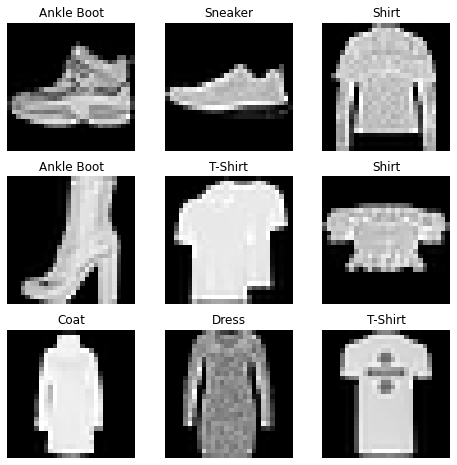

In [15]:
# 데이터를 list처럼 index를 통해서 접근할 수 있음
# matplob을 이용해서 데이터 일부를 시각화해보기

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

figure = plt.figure(figsize=(8,8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
  sample_idx = torch.randint(len(training_data), size=(1,)).item() # 0 ~ 60000 사이의 정수를 텐서에 담아서 출력 -> item에 의해서 텐서의 내용물인 랜덤수가 출력
  img, label = training_data[sample_idx]
  figure.add_subplot(rows, cols, i)
  plt.title(labels_map[label])
  plt.axis('off')
  plt.imshow(img.squeeze(), cmap='gray') # squeeze : 차원 중 1인것을 제거 예:) (2.1) --> (2,) 이미지를 출력할때 생기는 사이즈 문제를 해결하기 위해서 사용한것
plt.show()

### 파일에서 __사용자 정의__ 데이터셋 만들기

In [10]:
# 사용자 정의 Dataset 클래스는 반드시 3개 함수를 구현해야 함 ( __init__, __len__, __getitem__)

import os
import pandas as pd
from torchvision.io import read_image

class CustomImageDataset(Dataset):
  def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
    self.img_labels = pd.read_csv(annotations_file, names=['file_name', 'label'])
    self.img_dir = img_dir
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.img_labels)

  def __getitem__(self, idx):
    img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])  # join : 두 문자열을 일어주며 필요하다면 '/'를 추가할 수 있음 
    image = read_image(img_path)                                         # ---> img_path : 파일 경로 + 파일이름
    label = self.img_labels.iloc[idx, 1]
    if self.transform:
      image = self.transform(image)
    if self.target_transform:
      label = self.target_transform(label)
    return image, label


##### 함수 설명

- __init__ 함수는 Dataset객체가 생성될 떄 한번만 실행됨. 
  - 여기서는 아래의 것들을 초기화함
  - 이미지 주석파일(annotation_file)이 포함된 디렉토리
  - 두가지 변형(다음 장에서 자세히 배움)
  

- __len__ 함수는 데이터셋의 샘플 개수를 반환

- __getitem__ 함수는 주어진 인덱스 idx에 해당하는 샘플을 데이터셋에서 불러오고 반환
  - idx         :  위치 식별
  - read_image  :  이미지를 텐서롤 변경
  - self.img_labels : csv 데이터로부터 해당하는 정답(label) 가져오기

### DataLoader로 학습용 데이터 준비하기

In [12]:
from torch.utils.data import DataLoader # 모델을 학습시키기 전에 DataLoader를 통해 간단히 설정 가능

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True) # mini_batch: 64. 매번 에포크마다 샘플을 섞어서 진행
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

### DataLoader를 통해 순회하기(iterate)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


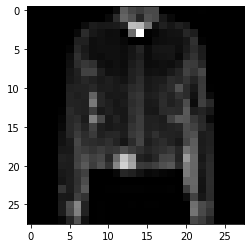

Label: 4


In [16]:
# 이미지와 정답(label)을 표시함

train_features, train_labels = next(iter(train_dataloader)) # 객체를 iterable하게 만들고 item을 반환함 (아마도 첫번째 묶음이 들어갈듯)
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f'Label: {label}')